In [1]:
%matplotlib inline

import numpy as np # NUMPY
import pandas as pd # PANDAS
import matplotlib.pyplot as plt # MATPLOTLIB
import seaborn as sns # SEABORN
import scipy
import sklearn
import random as rd
from sklearn.decomposition import PCA
from IPython.display import display
import os 
from pathlib import Path
import shutil 
import cv2

# En este notebook, primero escribimos en un archivo los datos para mejor acceso, luego los alineamos, y luego conseguimos el atributo shape (b_shape ) de nuestras imagenes

## Luego aqui exploraremos como conseguir imagenes nuevas. Deberia ser conseguir los landmarks --> Usar procustres con la shape de referencia y alinear landmarks y warpear imagenes

## Assumptions :

Cada secuencia muestra 1 de las 6 emociones básicas

La primer frame de cada secuencia muestra  la cara en una expression neutral

La intensidad de la expresion aumenta en cada frame de un sujeto (siendo intesidad 1 el ultimo frame. Otros no asumen la mayor intensidad en ultimo frame, nosotros si)

Aca para imagen nueva vamos a tener que usar aam para conseguir los landmarks. Por ahora vamos a extraer el feature 
b_shape para nuestra c_mock que usaremos de entrenamiento (mock)

we need to understansd the landmarks (annotaste) and the aam for the test image (input images)
#TO DO

### Cargamos y formateamos datos en orden de la  ck+ database

In [6]:
def get_landmarks_of_folder(files_vector):
    frames_landmarks_XYord = []
    for i in np.sort(files_vector):
        file_landmarks = get_landmarks_of_file(i)
        frames_landmarks_XYord.append(file_landmarks)
    frames_landmarks_XYord = np.asarray(frames_landmarks_XYord)
    return frames_landmarks_XYord

def get_landmarks_of_file(f):
    data = pd.read_csv(f, header = None)
    data.columns =['landmarks']
    quantity_of_landmarks = data.size #68
    data = data['landmarks'].str.split('   ', expand=True)
    data.columns =['landmarks', 'landmarkX', 'landmarkY']
    data =data.drop(columns=['landmarks'])
    landmarkXY= pd.concat([data['landmarkX'], data['landmarkY'] ], ignore_index=True)
    landmarkXY_array = landmarkXY.to_numpy(dtype=float)
    return landmarkXY_array
    
    


In [7]:

import glob

path = '../ck+copyAgainT/Landmarks/'

files = [f for f in glob.glob(path + "**/*.txt", recursive=True)]
files
frames_lmarks_XYord = get_landmarks_of_folder(files)


In [5]:

frames_landmarks_XYord.shape

NameError: name 'frames_landmarks_XYord' is not defined

True

In [88]:
my_df = pd.DataFrame(frames_landmarks_XYord)
my_df.to_csv('ckAgainT_landmark_rawData.csv',header = False, index= False)

#### Landmarks

### Aca convertimos  en array y agrupamos por secuencia de imagenes

### Aca  convertimos en array y apilamos todos los frames de todas las secuencias

### El orden de rawData es [x1...xn, y1..yn]

### Aca  separamos las primeras frames de cada secuencia, ( cara  neutral), y la cantidad de frames por secuencia, para poder luego sacar las diferencia entre los landmarks de los frames de una secuencia  y el primer frame de esta (cara neutral). 

In [8]:
def get_first_frames_and_cant_of_vector_of_seq(vector_of_sec):
    series = np.sort(vector_of_sec)
    first_frames_per_seq = []
    cant_frames_per_seq = []
    for se in series:
        first_frame, cant_frame = get_first_frame_and_cant_frames_of_seq(se)
        first_frames_per_seq.append(first_frame)
        cant_frames_per_seq.append(cant_frame)
    first_frames_per_seq = np.asarray(first_frames_per_seq)
    cant_frames_per_seq = np.asarray(cant_frames_per_seq)
    return first_frames_per_seq, cant_frames_per_seq



def get_first_frame_and_cant_frames_of_seq(se):
    seriespath = se + '/'
    seq_frames = np.sort(os.listdir(seriespath))
    seq_firstframe_path = seriespath + seq_frames[0]   
    ser_frames_quantity = len(np.sort(os.listdir(seriespath)))
    return seq_firstframe_path, ser_frames_quantity

In [8]:
path = '../ck+copyAgainT/Landmarks/'

series = [f for f in glob.glob(path + "**/0*",recursive=True) if os.path.isdir(f)]
series = np.sort(series)
first_frames_per_seq, cant_frames_per_seq =  get_first_frames_and_cant_of_vector_of_seq(series)

In [12]:
cant_frames_per_seq.shape

#quedaron 221 series.
#los sujetos siguen siendo 86
#las frames ahora son unas menos (4064)

(221,)

In [14]:
my_df = pd.DataFrame(first_frames_per_seq)
my_df.to_csv('ckAgainT_landmark_firstFrame.csv',header = False, index= False)
#no están alineados

In [15]:
my_df = pd.DataFrame(cant_frames_per_seq)
my_df.to_csv('cknewAgainT_landmark_FramePerSeq.csv',header = False, index= False)

In [44]:
path_of_used_series_landmarks

['../ck+copyAgainT/Landmarks/S010/002/S010_002_00000001_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S010/002/S010_002_00000014_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S010/004/S010_004_00000001_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S010/004/S010_004_00000019_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S010/006/S010_006_00000001_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S010/006/S010_006_00000015_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S011/001/S011_001_00000001_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S011/001/S011_001_00000016_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S011/002/S011_002_00000001_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S011/002/S011_002_00000021_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S011/002/S011_002_00000022_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S011/003/S011_003_00000001_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S011/003/S011_003_00000013_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S011/003/S011_003_00000014_landmark

In [41]:
f, i = path_of_landmarks_and_images("../ck+copyAgainT/")

In [40]:
def path_of_landmarks_and_images(globpath, quantity= 1):
  path_of_used_series_landmarks = []
  path_of_used_series_images = []
  for i in np.sort(glob( globpath +"Landmarks/*/*/", recursive = True)):
    subject = i.split('/')[3]
    serie = i.split('/')[4]
    actual = subject + '/'+ serie
    path = globpath + 'Emotion_labels/Emotion/' +actual + '/'
    image_path = globpath +'extended-cohn-kanade-images/cohn-kanade-images/' +actual+ '/'
    landmark_path = globpath +'Landmarks/' + actual+ '/'
    filelabel = (os.listdir(path))[0]
    longitud = np.sort((os.listdir(str(i))))
    imagelabel = np.sort(os.listdir(str(image_path)))
    landmarklabel = np.sort(os.listdir(str(landmark_path)))
    with open(path+ '/'+filelabel) as f:
        line = float(f.readline())
    if line == 4 or line == 6:
        path_of_used_series_landmarks.append(landmark_path + landmarklabel[0])
        path_of_used_series_images.append(image_path + imagelabel[0])
        for i in range(quantity,0):
            path_of_used_series_landmarks.append(landmark_path + landmarklabel[len(longitud)-quantity*2])
            path_of_used_series_landmarks.append(landmark_path + landmarklabel[len(longitud)-quantity])
            path_of_used_series_images.append(image_path + imagelabel[len(longitud)-quantity*2])
            path_of_used_series_images.append(image_path + imagelabel[len(longitud)-quantity])
    else:
        path_of_used_series_landmarks.append(landmark_path + landmarklabel[0])
        path_of_used_series_images.append(image_path + imagelabel[0])
        for i in range(quantity,0):
            
            path_of_used_series_landmarks.append(landmark_path + landmarklabel[len(longitud)-quantity])
            path_of_used_series_images.append(image_path + imagelabel[len(longitud)-quantity])
  return path_of_used_series_landmarks, path_of_used_series_images

### Aca sacamos las imagenes y hacemos un ejemplo para ver que se visualizen. Luego las alinearemos.

In [9]:
#Vamos a sacar la primera y última frame de cada serie, asi como las neutrales que sobran..
#.(no, las neutrales que sobran combiene sacarlas al final.)
#Si es de fear o sadness, sacamos las dos últimas
from glob import glob

path_of_used_series_landmarks = []
path_of_used_series_images = []
for i in np.sort(glob("../ck+copyAgainT/Landmarks/*/*/", recursive = True)):
    subject = i.split('/')[3]
    serie = i.split('/')[4]
    actual = subject + '/'+ serie
    path = '../ck+copyAgainT/Emotion_labels/Emotion/' +actual + '/'
    image_path = '../ck+copyAgainT/extended-cohn-kanade-images/cohn-kanade-images/' +actual+ '/'
    landmark_path = '../ck+copyAgainT/Landmarks/' + actual+ '/'
   
    filelabel = (os.listdir(path))[0]
    longitud = np.sort((os.listdir(str(i))))    
    imagelabel = np.sort(os.listdir(str(image_path))) 
    landmarklabel = np.sort(os.listdir(str(landmark_path)))
    with open(path+ '/'+filelabel) as f:        
        line = float(f.readline())         
    if line == 4 or line == 6:
        path_of_used_series_landmarks.append(landmark_path + landmarklabel[0])
                path_of_used_series_landmarks.append(landmark_path + landmarklabel[len(longitud)-4])
        path_of_used_series_landmarks.append(landmark_path + landmarklabel[len(longitud)-3]) 
        path_of_used_series_landmarks.append(landmark_path + landmarklabel[len(longitud)-2])
        path_of_used_series_landmarks.append(landmark_path + landmarklabel[len(longitud)-1])     
        path_of_used_series_images.append(image_path + imagelabel[0])
         path_of_used_series_images.append(image_path + imagelabel[len(longitud)-4])
        path_of_used_series_images.append(image_path + imagelabel[len(longitud)-3])       
        path_of_used_series_images.append(image_path + imagelabel[len(longitud)-2])
        path_of_used_series_images.append(image_path + imagelabel[len(longitud)-1])       
    else:
        path_of_used_series_landmarks.append(landmark_path + landmarklabel[0])
        path_of_used_series_landmarks.append(landmark_path + landmarklabel[len(longitud)-1])       
        path_of_used_series_images.append(image_path + imagelabel[0])
        path_of_used_series_images.append(image_path + imagelabel[len(longitud)-1])    
        
path_of_used_series_images

#vamos a hacer el pca con las neutrales y sin las neutrales.
path_of_used_series_landmarks


['../ck+copyAgainT/Landmarks/S010/002/S010_002_00000001_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S010/002/S010_002_00000014_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S010/004/S010_004_00000001_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S010/004/S010_004_00000019_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S010/006/S010_006_00000001_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S010/006/S010_006_00000015_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S011/001/S011_001_00000001_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S011/001/S011_001_00000016_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S011/002/S011_002_00000001_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S011/002/S011_002_00000021_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S011/002/S011_002_00000022_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S011/003/S011_003_00000001_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S011/003/S011_003_00000013_landmarks.txt',
 '../ck+copyAgainT/Landmarks/S011/003/S011_003_00000014_landmark

In [ ]:
path_of_landmarks_and_images

In [90]:
frames_lmarks_XYord = get_landmarks_of_folder(path_of_used_series_landmarks)

In [91]:
my_df = pd.DataFrame(frames_lmarks_XYord)
my_df.to_csv('ckAgainT_landmark_rawData1.csv',header = False, index= False)

In [93]:

#import glob

#path = '../ck+copyAgainT/extended-cohn-kanade-images/cohn-kanade-images/'

#images = [f for f in glob.glob(path + "**/*.png", recursive=True)]

#images = np.sort(np.asarray(images))
#print(images)
images = path_of_used_series_images
images = np.sort(np.asarray(images))

In [33]:
#See if loading image works
img= cv2.imread(images[0])

img =cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_width, img_height = img.shape
print(img.shape)

cv2.imshow("Face landmark result", img)

# Pause screen to wait key from user to see result
cv2.waitKey(0)
cv2.destroyAllWindows()

(490, 640)


# Alineación de shapes con procustres.

## Ahora, para que todas nuestras imagenes estén alineadas, utilizamos Procustres analysis. 

Este analisis, en su version normal, utiliza una imagen de referencia y luego encuentra las transformaciones de rotacion,  translacion y escala que minimizen la diferencia con esa imagen 

(La versión generalizada en cambio ve las distancias de la aproximacion de entre todos los pares y elije la imagen cuyas distancias son menores ) 



EL procustres de spicy devuelve los landmarks corridos, pero no devuelve 
las matrices de trasnformación, que son necesarias para luego hacer warp de las imagenes
en tiempo polinomial.

Acá primero lo hacemos con spicy (normal) y luego con un computo de procustres.
(normal y generalizado)

Vemos las diferencias y como dan los b_shapes con cada uno.

Luego, tambien usamos la transformacion para warpear las imágenes, y trabajamos a partir de ahora
con las imagenes y landmarks alineados.

we have todo procustres and we need noormalization of the landmark differences, (la normalizacion es la resta)

In [58]:
my_data = pd.read_csv('ckAgainT_landmark_rawData1.csv',header = None)
my_data #estas son las shapes sin la diferencia [x1...xl,y1..yl]

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,265.05080,265.13428,266.58159,273.10711,285.15946,305.64791,326.26631,351.72812,383.57231,416.07659,...,403.72105,384.33970,365.11442,352.87200,351.19562,351.41728,365.42821,383.16643,393.74353,381.33123
1,263.46593,263.25706,264.66220,271.52795,284.62917,303.07327,323.91687,350.09766,382.97743,416.70692,...,415.08705,392.25131,368.14104,351.75034,348.11725,350.40814,369.70181,392.83535,405.86390,390.53949
2,262.17231,262.70855,264.85444,270.15035,279.17107,296.19858,320.53947,349.46857,380.96274,412.12052,...,371.06109,359.33467,354.09625,353.18286,354.55692,352.27785,352.28454,353.21260,355.92060,354.05096
3,262.26276,262.81201,265.15302,272.00745,281.51414,299.37037,324.88948,353.53658,385.88518,417.13351,...,354.34082,349.85929,347.05330,346.31924,349.11638,345.92457,345.88359,346.44445,349.40795,347.09218
4,261.22887,262.80124,264.93049,272.36015,279.59691,299.26460,325.31751,355.42008,388.25720,419.66323,...,367.27843,356.19891,349.47686,351.47429,352.88706,349.84100,347.97711,350.23075,353.71023,351.76044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,123.45342,123.74975,127.81968,132.14847,138.92082,155.89584,181.76012,214.42939,249.92372,286.34203,...,371.44188,368.15404,351.77379,351.71558,351.41406,352.15952,352.27746,352.39540,351.53221,351.83200
476,123.46132,123.79075,127.92275,132.29111,139.40987,157.15826,182.23382,214.16033,249.73925,286.73432,...,358.97388,354.58675,348.70893,348.63259,348.17603,349.07385,349.17370,349.27354,348.29813,348.78527
477,129.01114,126.15220,129.81701,134.03668,140.04690,157.76268,185.15502,219.46098,255.62027,291.83419,...,353.63515,350.38548,336.24029,336.09493,335.40732,336.39002,336.48858,336.58715,335.44847,336.38565
478,115.11577,112.23193,116.45522,121.99641,126.69982,142.82142,170.81914,205.45261,242.34578,279.80245,...,373.88288,367.71043,348.26640,335.67124,336.99358,338.87440,348.96750,359.06061,361.10281,360.86157


### En estas 2 celdas cambiamos el formato, para tener los datos en forma intercalada (x1,y1,x2,y2) y xy (x1,x2..xn,y1,y2..yn). Usamos este último para b_shape como dice el paper, pero para procuestres lo usamos en orden intercalado (de a pares)

In [59]:

#Cambiamos a [x1, y1, x2,y2]
#Ahora lo hacemos en pares
def intercalate_datavector(vector):    
    x_coord = vector[0:int(len(vector)/2)]    
    y_coord = vector[int(len(vector)/2):len(vector)]
    output = []
    for (a, b) in zip(x_coord, y_coord):
        output.append(a)
        output.append(b)     
    return np.asarray(output)

def intercalate_data_of_datavectors(vectors, pairs):
    intercalated_data = []
    for i in range(0, len(vectors)):
        if (pairs == 0):
            intercalated = intercalate_datavector(vectors.iloc[i])
        else:
            intercalated = intercalate_datavector_as_pairs(vectors.iloc[i])
        intercalated_data.append(intercalated)
    intercalated_data = np.asarray(intercalated_data)
    return intercalated_data
        
def intercalate_data_of_vectors(vectors, pairs):
    intercalated_data = []
    for i in range(0, len(vectors)):
        if (pairs == 0):
            intercalated = intercalate_datavector(vectors[i])
        else:
            intercalated = intercalate_datavector_as_pairs(vectors[i])
        intercalated_data.append(intercalated)
    intercalated_data = np.asarray(intercalated_data)
    return intercalated_data 

def intercalate_datavector_as_pairs(vector):
    x_coord = vector[0:int(len(vector)/2)]    
    y_coord = vector[int(len(vector)/2):len(vector)]
    output = []
    for (a, b) in zip(x_coord, y_coord):
        output.append(np.array([a,b]))            
    return np.asarray(output)

intercalated_data = intercalate_data_of_datavectors(my_data, 0)


In [60]:
my_df = pd.DataFrame(intercalated_data)
my_df.to_csv('ckAgainT_landmark_intercalated_data1.csv',header = False, index= False)

Procustres
#Usamos la primera imagen como shape de referencia (puede generalizarse)

True

In [61]:

        
def opa(a, b):# a, b matrices de puntos [[],[],[]] a and b need to have same dimension
    aT = a.mean(0) # column mean [[1,2,3],[1,2,3]]<-(1,2,3)
    bT = b.mean(0)
    A = a - aT  #We rest aT and bT to center the matrix (translation)
    B = b - bT
    aS = np.sum(A * A)**.5 #to see the scale, we first calculate square of squared sum
    bS = np.sum(B * B)**.5
    A /= aS  #we standarize the scale.
    B /= bS
    U, _, V = np.linalg.svd(np.dot(B.T, A)) # we get the principal values of the mult for getting the rotation more close 
    aR = np.dot(U, V) #<-the rotation matrix is the multiplication of these 2
    if np.linalg.det(aR) < 0: # we rotate to the positive side
        V[1] *= -1
        aR = np.dot(U, V)
    aS = aS / bS  #to scale A most similar to B, we divide the scale by sSvale
    aT-= (bT.dot(aR) * aS) #to get the translation in B coordinates, rest b mean rotated to A, and scaled to A 
    aD = (np.sum((A - B.dot(aR))**2) / len(a))**.5  # the square distance (error)of the A and B rotated after scale and translation
    return aR, aS, aT, aD #return aROtation, aScale, aTranslation, Adifference
        
def gpa(v, n=-1): #v is vector of images, n indicates index to reflect
    if n < 0: 
        p = avg(v)
    else:
        p = v[n]
    l = len(v) #quantity of images
    r, s, t, d = np.ndarray((4, l), object) #4 array of len l, each a matrix
    for i in range(l):
        r[i], s[i], t[i], d[i] = opa(p, v[i]) 
    return r, s, t, d#<-calculates the matrix and the error for all images, you use the one with the smallest one (can iterate this)

def avg(v): #given a vector of images, calculates average shape of images 
    v_= np.copy(v)
    l = len(v_) 
    R, S, T = [list(np.zeros(l)) for _ in range(3)]
    for i, j in np.ndindex(l, l): #hace la daptacion de cada i para cada j
        r, s, t, _ = opa(v_[i], v_[j]) 
        R[j] += np.arccos(min(1, max(-1, np.trace(r[:1])))) * np.sign(r[1][0]) 
        S[j] += s 
        T[j] += t #ajusta rot, s y translacion en todo j con todo i
    for i in range(l):#hace el avg dado todo j
        a = R[i] / l
        r = [np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]
        v_[i] = v_[i].dot(r) * (S[i] / l) + (T[i] / l) 
    return v_.mean(0)

In [7]:
#Hacemos un ejemplo con procustres 1 y luego con procustres spatial, vemos las diferencias

In [21]:
import matplotlib.cm as cm 
my_landmarks = pd.read_csv('ckAgainT_landmark_intercalated_data1.csv',header = None)
even = np.asarray(my_landmarks.iloc[0][::2] )
odds = np.asarray( my_landmarks.iloc[0][1::2] )

even1 = np.asarray(my_landmarks.iloc[300][::2] )
odds1 = np.asarray( my_landmarks.iloc[300][1::2] )

lan =[]
for (a, b) in zip(even, odds):
    lan.append(np.asarray([a,b]))
    
lan1 =[]
for (a, b) in zip(even1, odds1):
    lan1.append(np.asarray([a,b]))

    

# Open images...
target_X_img = cv2.imread(all_images[0],0)
input_Y_img = cv2.imread(all_images[300],0)

# Landmark points - same number and order!
# l eye, r eye, nose tip, l mouth, r mouth
X_pts = np.asarray(lan)
Y_pts = np.asarray(lan1)

# Calculate transform via procrustes...

r,s,tr, d= opa(X_pts,Y_pts)

# Build and apply transform matrix...
# Note: for affine need 2x3 (a,b,c,d,e,f) form
R = np.eye(3)
R[0:2,0:2] = r
S = np.eye(3) * s
S[2,2] = 1
t = np.eye(3)
t[0:2,2] = tr
M = np.dot(np.dot(R,S),t.T).T
tr_Y_img = cv2.warpAffine(input_Y_img,M[0:2,:],(640,490))

#transform deberia hacer el a[1] = a[1].dot(r) * s + t
Z_pts = Y_pts.dot(r) * s + tr
# Confirm points...
aY_pts = np.hstack((Y_pts,np.array(([np.ones(68)])).T))
tr_Y_pts = np.dot(M,aY_pts.T).T



NameError: name 'all_images' is not defined

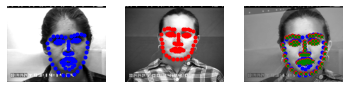

In [29]:
# Show result - input transformed and superimposed on target...
plt.figure() 
plt.subplot(1,3,1)
plt.imshow(target_X_img,cmap=cm.gray)
plt.plot(X_pts[:,0],X_pts[:,1],'bo',markersize=3)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(input_Y_img,cmap=cm.gray)
plt.plot(Y_pts[:,0],Y_pts[:,1],'ro',markersize=3)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(target_X_img,cmap=cm.gray)
plt.imshow(tr_Y_img,alpha=0.6,cmap=cm.gray)
plt.plot(X_pts[:,0],X_pts[:,1],'bo',markersize=3) 
plt.plot(Z_pts[:,0],Z_pts[:,1],'ro',markersize=3) # same as...
plt.plot(tr_Y_pts[:,0],tr_Y_pts[:,1],'gx',markersize=3)
plt.axis('off')
plt.show()

In [40]:

from scipy.spatial import procrustes

mtx1, mtx2, disparity = procrustes(lan,lan1)


### No dan iguales, ver porque luego. Ahora usamos el procurstres manual por ser el que nos permite transformar las imagenes

In [1]:
#Z_pts

In [2]:
#mtx2

In [ ]:
### Vamos a hacerlo con todas las imagenes ahora

In [107]:
def align_and_transform_image(reference_image, reference_landmarks, landmarks, images):
    even = np.asarray(reference_landmarks[::2] )
    odds = np.asarray( reference_landmarks[1::2] )
    target_X_img = cv2.imread(reference_image,0)
    lan =[]
    for (a, b) in zip(even, odds):
        lan.append(np.asarray([a,b]))  
    
    even1 = np.asarray(landmarks[::2] )
    odds1 = np.asarray( landmarks[1::2] )
    lan1 =[]
    for (a, b) in zip(even1, odds1):
        lan1.append(np.asarray([a,b]))
    
    X_pts = np.asarray(lan)
    Y_pts = np.asarray(lan1)
    
    input_Y_img = cv2.imread(images)
    
    r,s,tr, d= opa(X_pts,Y_pts)
    # Build and apply transform matrix...
    # Note: for affine need 2x3 (a,b,c,d,e,f) form
    R = np.eye(3)
    R[0:2,0:2] = r
    S = np.eye(3) * s
    S[2,2] = 1
    t = np.eye(3)
    t[0:2,2] = tr
    M = np.dot(np.dot(R,S),t.T).T
    tr_Y_img = cv2.warpAffine(input_Y_img,M[0:2,:],(640,490))

    
    #transform deberia hacer el a[1] = a[1].dot(r) * s + t
    Z_pts = Y_pts.dot(r) * s + tr
    
    return tr_Y_img, Z_pts 
    

def align_and_transform_datavector_of_images(reference_image, reference_landmarks, landmarks, images, pathi):        
    transformed_landmarks_total = []        
    for i in range(0, len(landmarks)):
        print(images[i].split('/')[6])
        tr_Y_img, Z_pts = align_and_transform_image(reference_image, reference_landmarks, landmarks.iloc[i], images[i])        
        transformed_landmarks_total.append(Z_pts)
        filename = 'warped_image_procustres_'+ str(images[i].split('/')[6]) 
        path = pathi
        cv2.imwrite(os.path.join(path , filename), tr_Y_img)      
    transformed_landmarks_total = np.asarray(transformed_landmarks_total)
    return transformed_landmarks_total


def align_and_transform_vector_of_images(reference_image, reference_landmarks, landmarks, images, pathi):        
    transformed_landmarks_total = []        
    for i in range(0, len(landmarks)):
        tr_Y_img, Z_pts = align_and_transform_image(reference_image, reference_landmarks, landmarks[i], images[i])        
        transformed_landmarks_total.append(Z_pts)
        filename = 'warped_image_procustres_'+ str(images[i].split('/')[6]) 
        path = pathi
        cv2.imwrite(os.path.join(path , filename), tr_Y_img)      
    transformed_landmarks_total = np.asarray(transformed_landmarks_total)
    return transformed_landmarks_total

In [108]:
import matplotlib.cm as cm 
my_landmarks = pd.read_csv('ckAgainT_landmark_intercalated_data1.csv',header = None)
pathi = '../ck+warpedAgainT_V1'
transformed_landmarks_total = align_and_transform_datavector_of_images(images[0], my_landmarks.iloc[0], my_landmarks, images, pathi)

S010_002_00000001.png
S010_002_00000014.png
S010_004_00000001.png
S010_004_00000019.png
S010_006_00000001.png
S010_006_00000015.png
S011_001_00000001.png
S011_001_00000016.png
S011_002_00000001.png
S011_002_00000021.png
S011_002_00000022.png
S011_003_00000001.png
S011_003_00000013.png
S011_003_00000014.png
S011_004_00000001.png
S011_004_00000021.png
S011_005_00000001.png
S011_005_00000020.png
S011_006_00000001.png
S011_006_00000013.png
S014_001_00000001.png
S014_001_00000029.png
S014_002_00000001.png
S014_002_00000015.png
S014_002_00000016.png
S014_003_00000001.png
S014_003_00000030.png
S014_005_00000001.png
S014_005_00000017.png
S022_001_00000001.png
S022_001_00000030.png
S022_005_00000001.png
S022_005_00000032.png
S022_006_00000001.png
S022_006_00000017.png
S026_001_00000001.png
S026_001_00000015.png
S026_002_00000001.png
S026_002_00000015.png
S026_002_00000016.png
S026_003_00000001.png
S026_003_00000015.png
S026_006_00000001.png
S026_006_00000013.png
S029_001_00000001.png
S029_001_0

S119_008_00000018.png
S122_001_00000001.png
S122_001_00000012.png
S124_001_00000001.png
S124_001_00000014.png
S124_003_00000001.png
S124_003_00000010.png
S124_003_00000011.png
S124_006_00000001.png
S124_006_00000011.png
S124_007_00000001.png
S124_007_00000024.png
S125_001_00000001.png
S125_001_00000013.png
S125_001_00000014.png
S125_005_00000001.png
S125_005_00000013.png
S125_006_00000001.png
S125_006_00000021.png
S125_006_00000022.png
S125_007_00000001.png
S125_007_00000009.png
S125_008_00000001.png
S125_008_00000010.png
S126_001_00000001.png
S126_001_00000036.png
S126_001_00000037.png
S126_002_00000001.png
S126_002_00000021.png
S126_004_00000001.png
S126_004_00000012.png
S126_008_00000001.png
S126_008_00000029.png
S128_001_00000001.png
S128_001_00000024.png
S128_004_00000001.png
S128_004_00000013.png
S128_011_00000001.png
S128_011_00000016.png
S129_001_00000001.png
S129_001_00000011.png
S129_002_00000001.png
S129_002_00000011.png
S129_003_00000001.png
S129_003_00000024.png
S129_006_0

In [71]:
my_landmarks.iloc[0]

0      265.05080
1      235.20293
2      265.13428
3      267.96751
4      266.58159
         ...    
131    383.16643
132    384.38592
133    393.74353
134    363.44478
135    381.33123
Name: 0, Length: 136, dtype: float64

In [3]:
#transformed_landmarks_total[0]

In [96]:
len(transformed_landmarks_total)

480

In [4]:
#transformed_landmarks_total[0].flatten('F') #orden xy

In [98]:
transformed_final = transformed_landmarks_total[0].flatten('F')
for i in range (1, len(transformed_landmarks_total)):
    transformed_final = np.vstack((transformed_final, transformed_landmarks_total[i].flatten('F')))
transformed_final[0]


my_df = pd.DataFrame(transformed_final)
my_df.to_csv('transformed_landmarks_procustres_AgainTV1_totalxy.csv',header = False, index= False)

In [ ]:
#Ahora en el archivo arriba esta guardado los landmarks en orden x1-xn,y1-yn, listo para PCA.

### Ahora si, trabajamos con esta data alineada en orden xy. Luego de cargala, conseguimos la diferencia con cada frame 0 por secuencia, y con esos datos utilizamos PCA para  encontrar los b_shape, que tienen dimension #principal_component x 1 para cada frame . 

In [99]:
my_data = pd.read_csv('transformed_landmarks_procustres_AgainTV1_totalxy.csv',header = None)
my_data

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,265.050800,265.134280,266.581590,273.107110,285.159460,305.647910,326.266310,351.728120,383.572310,416.076590,...,403.721050,384.339700,365.114420,352.872000,351.195620,351.417280,365.428210,383.166430,393.743530,381.331230
1,268.372648,268.523696,270.196174,277.030778,289.745604,307.484740,327.475426,352.465115,383.631481,415.479025,...,410.033599,388.542133,365.812881,350.148823,346.495185,348.427939,366.548944,388.553865,401.089656,386.828793
2,257.326168,258.221938,260.805877,266.690325,276.474686,294.626252,320.389932,350.903551,384.016598,416.652835,...,381.291440,369.144658,363.629485,362.510836,363.795650,361.240308,361.083938,362.222985,365.226899,363.423345
3,253.460187,254.067610,256.607161,264.014142,274.281111,293.550897,321.081863,351.984111,386.873564,420.570991,...,365.650615,360.823577,357.793074,356.997512,360.010454,356.564389,356.516172,357.125080,360.324901,357.831171
4,254.903363,256.296142,258.279922,265.854494,273.228336,293.755002,321.060229,352.685877,387.297974,420.440242,...,380.992998,369.192722,362.104119,364.336818,365.953482,362.861085,361.016295,363.270506,366.821005,364.637481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,246.472393,248.380416,254.059928,260.002762,268.385993,286.878623,313.995946,347.537238,383.367737,419.716659,...,374.724052,372.139460,355.797698,355.228702,353.839377,353.498967,353.093587,353.751973,353.963433,355.355260
476,241.817575,243.919839,249.920766,256.169473,265.235114,285.103781,312.265039,346.062300,383.044500,420.954278,...,361.843715,357.958485,352.069562,351.505764,350.050926,349.858959,349.418582,350.081371,350.176998,351.665389
477,246.884274,245.567993,250.834303,256.640029,264.260362,283.502885,312.177996,347.341648,383.992157,420.255053,...,371.250844,368.623758,354.486332,353.861859,352.152094,352.137879,351.761961,352.348319,352.192229,354.161028
478,249.916927,248.522125,254.106740,260.984156,267.035487,284.188326,312.658089,347.272305,383.658269,420.271966,...,383.790889,378.627447,359.392009,346.452478,346.574275,347.169828,356.476551,366.957381,370.283189,371.253189


In [28]:
#cant_frames_per_seq = pd.read_csv('cknewT_landmark_FramePerSeq.csv',header = None)
#cant_frames_per_seq =np.asarray(cant_frames_per_seq).flatten()

In [29]:
#### Aqui hacemos las diferencias entre los landmarks de una secuencia, siempre contra su frame 0




#ind =0
#my_data_aligned_diff =[]
#for i in range(0, len(cant_frames_per_seq)):#51
#    cant_frames = cant_frames_per_seq[i]
#    frame_zero = my_data.iloc[ind]    
#    for j in range(ind, ind + cant_frames):
#        my_data_aligned_diff.append(my_data.iloc[j]- my_data.iloc[ind]) #no dice nada de abs
#    ind = ind + cant_frames
    
#my_data_aligned_diff = np.asarray(my_data_aligned_diff)

In [109]:
len(my_data)

480

In [118]:
ind = 0
my_data_aligned_diff = []
images_names = np.sort(os.listdir('../ck+warpedAgainT_V1'))
current_neutral_index = 0
for i in range(0, len(images_names)):
    if int(images_names[i].split('_')[5].split('.')[0]) == 1:
        current_neutral_index = i
        print('cambie neutral '+ str(current_neutral_index))
    
    my_data_aligned_diff.append(my_data.iloc[i]- my_data.iloc[current_neutral_index])
    
        
my_data_aligned_diff = np.asarray(my_data_aligned_diff)    

cambie neutral 0
cambie neutral 2
cambie neutral 4
cambie neutral 6
cambie neutral 8
cambie neutral 11
cambie neutral 14
cambie neutral 16
cambie neutral 18
cambie neutral 20
cambie neutral 22
cambie neutral 25
cambie neutral 27
cambie neutral 29
cambie neutral 31
cambie neutral 33
cambie neutral 35
cambie neutral 37
cambie neutral 40
cambie neutral 42
cambie neutral 44
cambie neutral 46
cambie neutral 48
cambie neutral 50
cambie neutral 53
cambie neutral 55
cambie neutral 57
cambie neutral 59
cambie neutral 61
cambie neutral 63
cambie neutral 65
cambie neutral 67
cambie neutral 69
cambie neutral 71
cambie neutral 73
cambie neutral 75
cambie neutral 77
cambie neutral 79
cambie neutral 81
cambie neutral 84
cambie neutral 86
cambie neutral 88
cambie neutral 90
cambie neutral 92
cambie neutral 94
cambie neutral 96
cambie neutral 98
cambie neutral 100
cambie neutral 102
cambie neutral 104
cambie neutral 107
cambie neutral 109
cambie neutral 111
cambie neutral 113
cambie neutral 115
cambie 

In [119]:
my_df = pd.DataFrame(my_data_aligned_diff)
my_df.to_csv('my_training_data_aligned_diff_AgainT_V1.csv',header = False, index= False)

# Ahora hacemos PCA

En el paper nos dice que restaramos el mean por columna, nosotros tambien normalizamos por standard deviation (dividimos).
La cantidad de xomponentes es la minima que alcanze un 99% loadings, en este caso 38.

In [8]:
my_data_forPCA = pd.read_csv('my_training_data_aligned_diff_AgainT_V1.csv',header = None)
my_data_forPCA

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.321848,3.389416,3.614584,3.923668,4.586144,1.836830,1.209116,0.736995,0.059171,-0.597565,...,6.312549,4.202433,0.698461,-2.723177,-4.700435,-2.989341,1.120734,5.387435,7.346126,5.497563
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-3.865982,-4.154327,-4.198715,-2.676183,-2.193575,-1.075355,0.691931,1.080560,2.856966,3.918157,...,-15.640824,-8.321081,-5.836411,-5.513324,-3.785196,-4.675919,-4.567765,-5.097905,-4.901998,-5.592174
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
476,-4.654817,-4.460577,-4.139162,-3.833289,-3.150879,-1.774842,-1.730907,-1.474938,-0.323237,1.237619,...,-12.880337,-14.180975,-3.728136,-3.722938,-3.788450,-3.640007,-3.675006,-3.670601,-3.786435,-3.689871
477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
478,3.032653,2.954132,3.272437,4.344127,2.775125,0.685441,0.480092,-0.069342,-0.333888,0.016912,...,12.540045,10.003689,4.905677,-7.409381,-5.577819,-4.968051,4.714590,14.609063,18.090960,17.092161


In [ ]:
#lo hacemos con las neutrales extra y sin las neutrales extra

In [9]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaler = std_scaler.fit(my_data_forPCA)
scaled_landDiff = scaler.transform(my_data_forPCA)
scaled_landDiff.shape

(480, 136)

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=29)
pac = pca.fit(scaled_landDiff)
b_shape = pac.transform(scaled_landDiff)
b_shape.shape # cada fila deberia ser el b de 1 frame en 5 componentes proncipales (de 136 2*l landmarks)

(480, 29)

In [11]:
import pickle as pk

with open('scaler_shapeWNeu.pkl', 'wb') as pickle_file:
        pk.dump(scaler, pickle_file)
with open('scaler_shapeWNeu.pkl', 'rb') as pickle_file:
    sl = pk.load(pickle_file)
with open('pca_shapeWNeu.pkl', 'wb') as pickle_file:
        pk.dump(pac, pickle_file)
with open('pca_shapeWNeu.pkl', 'rb') as pickle_file:
    pca = pk.load(pickle_file)

In [12]:
print(sum(pca.explained_variance_ratio_))

0.9633423333577948


In [13]:
my_df = pd.DataFrame(b_shape)
my_df.to_csv('pca_training_shapepoints_AgainT_V1_WNeu.csv',header = False, index= False)

In [7]:
##Ahora vamos a hacerlo sin las neutrales
ind = 0
my_data_forPCAARR = np.asarray(my_data_forPCA)
images_names = np.sort(os.listdir('../ck+warpedAgainT_V1'))
current_neutral_index = 0
my_data_for_PCA_SNeu = [] 
current_subject = 'start'
for i in range(0, len(images_names)):           
    if int(images_names[i].split('_')[5].split('.')[0]) == 1:
        if current_subject != images_names[i].split('_')[3]:
            current_subject = images_names[i].split('_')[3]
            my_data_for_PCA_SNeu.append(my_data_forPCAARR[i])
    else:
        my_data_for_PCA_SNeu.append(my_data_forPCAARR[i])
        
            
            
    #    current_neutral_index = i
    #    print('cambie neutral '+ str(current_neutral_index))
    
    #my_data_aligned_diff.append(my_data.iloc[i]- my_data.iloc[current_neutral_index])
    
        
my_data_for_PCA_SNeu = np.asarray(my_data_for_PCA_SNeu)
my_data_for_PCA_SNeu.shape

(331, 136)

In [8]:
my_df = pd.DataFrame(my_data_for_PCA_SNeu)
my_df.to_csv('my_data_for_PCA_SNeu_AgainT_V1.csv',header = False, index= False)


In [9]:
a = np.allclose(my_data_forPCA.iloc[1], my_data_forPCAARR[1])
a

True

In [ ]:
cada fila deberia ser el b de 1 frame en 5 componentes proncipales (de 136 puntos que eran 2*l landmarks)

## Aca deberiamos graficar el impacto de los principal componentes.

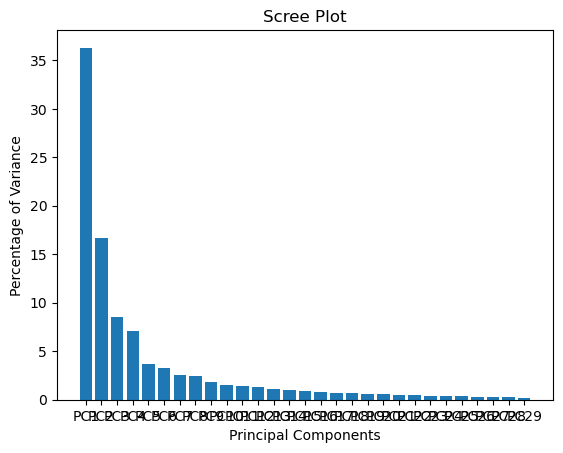

In [125]:
b_shape
pca_var=np.round(pca.explained_variance_ratio_* 100, decimals=1 )
labels = ['PC'+ str(s) for s in range(1, len(pca_var)+1)]

plt.bar(x= range(1, len(pca_var)+1), height = pca_var, tick_label= labels)
plt.ylabel("Percentage of Variance")
plt.xlabel("Principal Components")
plt.title("Scree Plot")
plt.show()

In [10]:
my_data_forPCA = pd.read_csv('my_data_for_PCA_SNeu_AgainT_V1.csv',header = None)
my_data_forPCA

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.321848,3.389416,3.614584,3.923668,4.586144,1.836830,1.209116,0.736995,0.059171,-0.597565,...,6.312549,4.202433,0.698461,-2.723177,-4.700435,-2.989341,1.120734,5.387435,7.346126,5.497563
2,-3.865982,-4.154327,-4.198715,-2.676183,-2.193575,-1.075355,0.691931,1.080560,2.856966,3.918157,...,-15.640824,-8.321081,-5.836411,-5.513324,-3.785196,-4.675919,-4.567765,-5.097905,-4.901998,-5.592174
3,-0.136320,-1.313733,-2.282231,-7.375097,-2.465058,-0.159549,-0.810970,-2.448364,-3.388743,-2.842376,...,9.724315,-1.734997,-16.076472,-19.692054,-15.550130,-21.177078,-16.788736,5.480343,9.073274,4.664294
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,1.893615,3.364163,3.580656,3.995410,4.716341,2.761186,1.657508,1.097704,0.183284,-1.057400,...,-1.346104,2.099311,1.635879,1.457069,0.263527,0.529622,0.623689,0.941206,0.287328,1.610309
327,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
328,-4.654817,-4.460577,-4.139162,-3.833289,-3.150879,-1.774842,-1.730907,-1.474938,-0.323237,1.237619,...,-12.880337,-14.180975,-3.728136,-3.722938,-3.788450,-3.640007,-3.675006,-3.670601,-3.786435,-3.689871
329,3.032653,2.954132,3.272437,4.344127,2.775125,0.685441,0.480092,-0.069342,-0.333888,0.016912,...,12.540045,10.003689,4.905677,-7.409381,-5.577819,-4.968051,4.714590,14.609063,18.090960,17.092161


In [16]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_landDiff = std_scaler.fit_transform(my_data_forPCA)
scaled_landDiff.shape

(331, 136)

In [17]:
import pickle
with open('scalerV1shape.pkl','wb') as f:
    pickle.dump(std_scaler, f)
with open('scalerV1shape.pkl','rb') as f:
    sc = pickle.load(f)

In [18]:
loaded_sd =sc.fit_transform(my_data_forPCA)
a = np.allclose(loaded_sd, scaled_landDiff)
a

True

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=29)
pca.fit_transform(scaled_landDiff)
b_shape = pca.fit_transform(scaled_landDiff)
b_shape.shape # cada fila deberia ser el b de 1 frame en 5 componentes proncipales (de 136 2*l landmarks)

(331, 29)

In [20]:
with open('pcaV1shape.pkl','wb') as f:
    pickle.dump(pca, f)
with open('pcaV1shape.pkl','rb') as f:
    pac = pickle.load(f)

In [21]:
pac

PCA(n_components=29)

In [23]:
print(sum(pca.explained_variance_ratio_))

0.9619173972196595


In [148]:
my_df = pd.DataFrame(b_shape)
my_df.to_csv('pca_training_shapepoints_AgainT_V1_SNeu.csv',header = False, index= False)

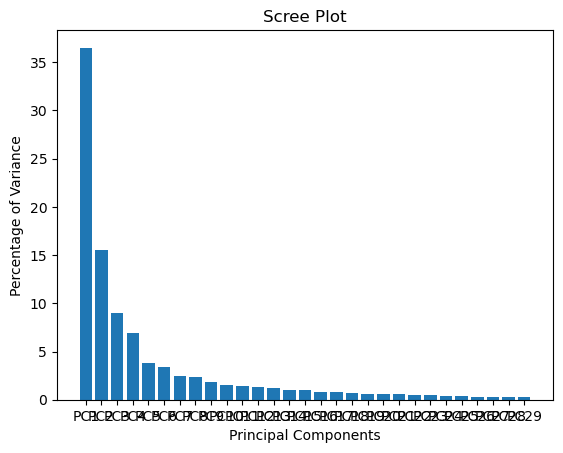

In [146]:
b_shape
pca_var=np.round(pca.explained_variance_ratio_* 100, decimals=1 )
labels = ['PC'+ str(s) for s in range(1, len(pca_var)+1)]

plt.bar(x= range(1, len(pca_var)+1), height = pca_var, tick_label= labels)
plt.ylabel("Percentage of Variance")
plt.xlabel("Principal Components")
plt.title("Scree Plot")
plt.show()

### Ahora si, trabajamos con esta data alineada en orden xy. Luego de cargala, conseguimos la diferencia con cada frame 0 por secuencia, y con esos datos utilizamos PCA para  encontrar los b_shape, que tienen dimension #principal_component x 1 para cada frame . 

In [2]:
my_data = pd.read_csv('ckmock_landmark_aligned_xy.csv',header = None)
my_data

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,-0.163450,-0.156895,-0.145752,-0.136284,-0.122597,-0.098510,-0.067956,-0.033574,0.005142,0.044869,...,0.087766,0.081893,0.069788,0.067553,0.066924,0.067827,0.070162,0.071911,0.072451,0.071782
1,-0.163450,-0.156895,-0.145752,-0.136284,-0.122597,-0.098510,-0.067956,-0.033574,0.005142,0.044869,...,0.087766,0.081893,0.069788,0.067553,0.066924,0.067827,0.070162,0.071911,0.072451,0.071782
2,-0.163450,-0.156895,-0.145752,-0.136284,-0.122597,-0.098510,-0.067956,-0.033574,0.005142,0.044869,...,0.087766,0.081893,0.069788,0.067553,0.066924,0.067827,0.070162,0.071911,0.072451,0.071782
3,-0.163462,-0.156908,-0.145755,-0.136281,-0.122597,-0.098517,-0.067972,-0.033580,0.005137,0.044863,...,0.087772,0.081898,0.069807,0.067551,0.066919,0.067826,0.070184,0.071954,0.072516,0.071826
4,-0.163406,-0.156854,-0.145720,-0.136245,-0.122544,-0.098467,-0.067924,-0.033558,0.005157,0.044874,...,0.087870,0.081942,0.069783,0.067510,0.066874,0.067786,0.070165,0.071976,0.072554,0.071843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,-0.148756,-0.148653,-0.147350,-0.142510,-0.125884,-0.099116,-0.067693,-0.034620,0.002989,0.042856,...,0.087104,0.081242,0.062722,0.061722,0.062258,0.058505,0.057794,0.058807,0.063288,0.062188
961,-0.148750,-0.148671,-0.147348,-0.142510,-0.125914,-0.099120,-0.067702,-0.034628,0.002981,0.042855,...,0.087195,0.081358,0.062807,0.061829,0.062320,0.058664,0.057920,0.058891,0.063298,0.062257
962,-0.148761,-0.148685,-0.147358,-0.142514,-0.125920,-0.099120,-0.067688,-0.034631,0.002974,0.042849,...,0.087149,0.081329,0.062785,0.061839,0.062338,0.058680,0.057926,0.058856,0.063253,0.062230
963,-0.148763,-0.148652,-0.147356,-0.142512,-0.125875,-0.099113,-0.067682,-0.034619,0.002988,0.042853,...,0.087044,0.081181,0.062667,0.061684,0.062242,0.058448,0.057757,0.058756,0.063262,0.062147


In [3]:
cant_frames_per_seq = pd.read_csv('ckmock_landmark_FramePerSeq.csv',header = None)
cant_frames_per_seq =np.asarray(cant_frames_per_seq).flatten()

In [4]:
ind =0
my_data_aligned_diff =[]
for i in range(0, len(cant_frames_per_seq)):#51
    cant_frames = cant_frames_per_seq[i]
    frame_zero = my_data.iloc[ind]    
    for j in range(ind, ind + cant_frames):
        my_data_aligned_diff.append(my_data.iloc[j]- my_data.iloc[ind]) #no dice nada de abs
    ind = ind + cant_frames
    
my_data_aligned_diff = np.asarray(my_data_aligned_diff)

In [7]:
my_df = pd.DataFrame(my_data_aligned_diff)
my_df.to_csv('my_data_aligned_diff.csv',header = False, index= False)

# Ahora hacemos PCA

En el paper nos dice que restaramos el mean por columna, nosotros tambien normalizamos por standard deviation (dividimos).
La cantidad de xomponentes es la minima que alcanze un 99% loadings, en este caso 38.

In [17]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_landDiff = std_scaler.fit_transform(my_data_aligned_diff)
scaled_landDiff.shape

(965, 136)

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=38)
pca.fit_transform(scaled_landDiff)
b_shape = pca.fit_transform(scaled_landDiff)
b_shape.shape # cada fila deberia ser el b de 1 frame en 38 componentes proncipales (de 136 2*l landmarks)

(965, 38)

In [19]:
print(sum(pca.explained_variance_ratio_))


0.9907696428747979


 cada fila deberia ser el b de 1 frame en 38 componentes proncipales (de 136 2*l landmarks)

## Aca deberiamos graficar el impacto de los principal componentes.